In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import argparse
import numpy as np
from scipy.optimize import curve_fit

In [42]:
parser = argparse.ArgumentParser(description='')
parser.add_argument('--file', '-f', type=list, help='Input file path')
files = ['Gain_NNVT_PN2305-1100_090824.csv']
options = ['-f', files]
args = parser.parse_args(args=options)

plt.style.use('seaborn-v0_8-colorblind')

In [43]:
brand_dict = {"ham": "Hamamatsu", "nnvt" : "NNVT", "NNVT":"NNVT", "HAM": "Hamamatsu"}
markers = ['o', 's', 'v', '^']
colors = ("b", "orange", "g", "r", "c", "m", "y", "k")

# Marker size is a bit small by default
msize = 20 #15
fontsize = 15

In [44]:
def Func_HV_Gain(x, s, c):
    return s*np.log10(x)+c

In [45]:

fname = args.file[0]
fdt = fname.split("_")[0]
df = pd.read_csv(fname)

# Assumes standarde file naming format
def get_v_from_fname(row):
    base = Path(row["fname"]).stem

    # Get brand model and voltage from filename
    brand, model, measurement, voltage = base.split("_")
    brand = brand_dict[brand]
    # Get rid of "v" in string if there
    if voltage[-1] == "V" or voltage[-1] == "v":
        voltage = voltage[:-1]

    return brand, model, measurement, float(voltage)

# Expand here means when apply returns multiple values, they get assigned to
# each given new column
df[["brand","model","measurement","v"]] = df.apply(get_v_from_fname, axis="columns", result_type="expand")

# Sort values by angles is in order
df = df.sort_values(["measurement","v"], ascending=True)

MPE-DarkBox
pmt PN2305-1100(New)
best fit parms [  7.7409087  -17.12968652]
HV at Gain=5E+6: 1197 [V]
MPE-Fridge
pmt PN2305-1100
best fit parms [  7.26584733 -15.66329105]
HV at Gain=5E+6: 1195 [V]
Original
pmt PN2305-1100
best fit parms [ 3.36424422 -3.93940892]
HV at Gain=5E+6: 1452 [V]
SPE
pmt PN2305-1100(New)
best fit parms [  6.98083134 -14.95783651]
HV at Gain=5E+6: 1265 [V]
SPE(LongGate)
pmt PN2305-1100(New)
best fit parms [  6.75291732 -14.17468065]
HV at Gain=5E+6: 1233 [V]
SPEMinusPed
pmt PN2305-1100(New)
best fit parms [  7.42411892 -16.35403055]
HV at Gain=5E+6: 1273 [V]
SPEMinusPed(LongGate)
pmt PN2305-1100(New)
best fit parms [  7.07415348 -15.18802514]
HV at Gain=5E+6: 1241 [V]


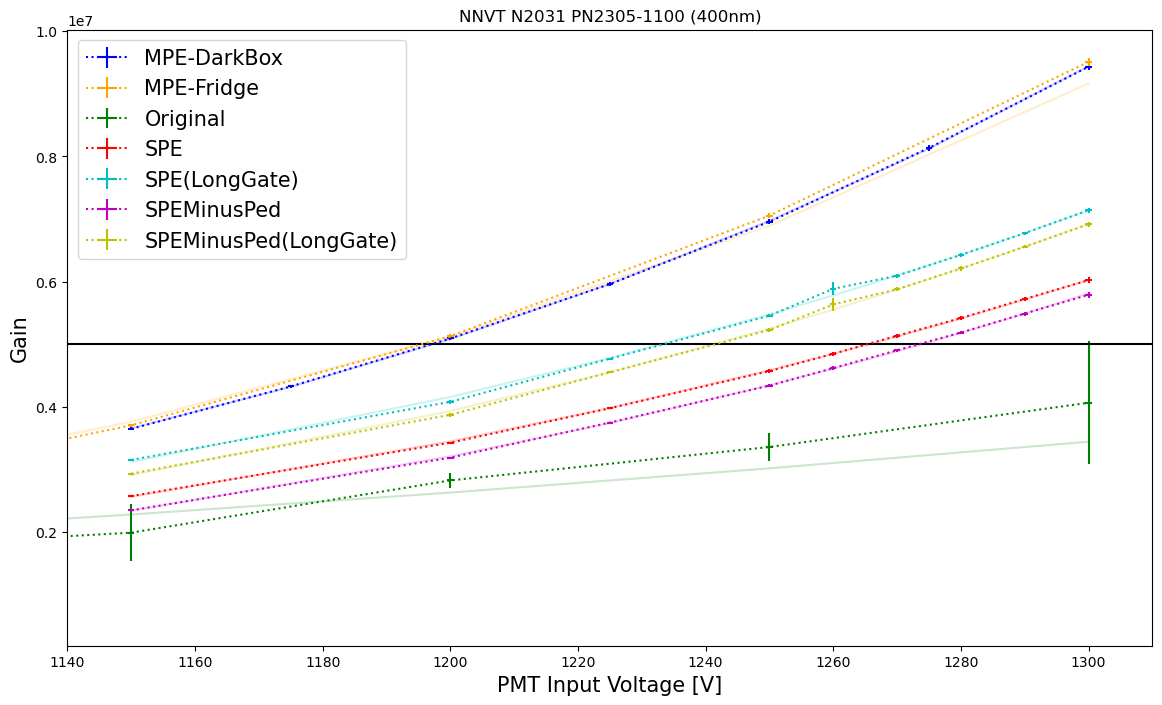

In [49]:
fig, ax = plt.subplots()

# Group by the measurement type and plot each value
df_joint = df.groupby("measurement")

gain = []
gain_err = []
hv = []

# Cycle through grouped df plotting each azimuthal angle
idx=0
for measur,df_m in df_joint:
    print(measur)

    gain = df_m['gain'].values
    gain_err = df_m['gain_err'].values
    hv = df_m['v'].values
    
    # Set the style based on PMT
    pmt = df_m["model"].values[0]
    print('pmt',pmt)
    if 'KM' in pmt:
        marker = markers[0]
        linestyle = '-'
    elif 'PN' in pmt:
        marker = markers[1]
        linestyle = ':'
    color=colors[idx]
    format_str = "{color}{marker}-".format(color=color, marker=marker)
    
    ax.errorbar(df_m['v'].values, y=gain, yerr = gain_err, xerr = 0.5, color=color,label=measur, linestyle=linestyle)
    idx+=1

    log_gain = np.log10(gain)
    log_gain_err = np.log10(gain_err)
    parms, cov = curve_fit(Func_HV_Gain, hv, log_gain, sigma=log_gain_err)
    print('best fit parms', parms)
    best_fit_gain = 10**np.array([ Func_HV_Gain(i, parms[0], parms[1]) for i in hv ])
    HV_gain_5e6 = 10**((np.log10(5e6)-parms[1])/parms[0])
    print('HV at Gain=5E+6: {:d} [V]'.format(int(HV_gain_5e6)))
    ax.plot(hv, best_fit_gain,color=color,alpha=0.2, linestyle='-')

ax.legend(fontsize=fontsize)
ax.set(xlim=(1140,1310))
ax.set_xlabel("PMT Input Voltage [V]",fontsize=fontsize)
ax.set_ylabel("Gain", fontsize=fontsize)
ax.axhline(5e6, linestyle='-', color='black', label=r'$5\times10^6$ (requirement)')
ax.title.set_text("NNVT N2031 PN2305-1100 (400nm)")
fig.set_size_inches(14,8)
fig.savefig("Gain_NNVT_CrossCheck.png",bbox_inches='tight')

plt.show()
